In [1]:
!pip install networkx

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [12]:
!pip install seaborn

     |████████████████████████████████| 293 kB 928 kB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [1]:
import networkx as nx

import os
import numpy as np
import matplotlib.pyplot as plt
import gc

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from spektral.data import Dataset, Graph
from spektral.layers import GraphSageConv
from spektral.utils import normalized_adjacency
from spektral.models.gcn import GCN 
from spektral.datasets.utils import DATASET_FOLDER

from scipy import sparse
from scipy.special import softmax

from sklearn.model_selection import train_test_split


In [2]:

def plot_graph_dir(G, communities=None):
    pos = nx.spring_layout(G, seed=42)
    
    if communities is not None:
        # Assign colors to nodes based on their communities
        colors = ['orange' if community == 0 else 'skyblue' for community in communities]
    else:
        colors = 'red'

    nx.draw_networkx(G, pos, arrows=True, node_color=colors, with_labels=True)
    plt.show()




# Caso 1: dirigido, mismo tamaño, NO balanceado (1a100), clases separadas

No dirigido, i.e. matriz de adyacencia simétrica

Todos los grafos del mismo tamaño: 100 nodos

Clases "separadas" (a juzgar por la representación gráfica)

In [3]:
class synthetic_Dir_100nodes_NoBalanced_1a100_clasesSep(Dataset):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    @property
    def path(self):
        return os.path.join(DATASET_FOLDER, "syntheticGraphs", self.__class__.__name__)
    
    def download(self):
        os.makedirs(self.path)
        
        def generate_synthetic_graph_csbm(n_nodes, n_communities, n_features, edge_prob_matrix, node_feature_means,\
                                  n_infected, semilla, indice, feature_cov_matrix=None):
            # Assign nodes to communities
            np.random.seed(semilla*(indice+1))
            indices = [np.random.randint(0,n_nodes) for i in range(n_infected)]
            communities = np.array([int(j in indices) for j in range(n_nodes)])

            # Generate node features
            if feature_cov_matrix is None:
                feature_cov_matrix = np.eye(n_features)
            features = np.zeros((n_nodes, n_features))
            for k in range(n_communities):
                nodes_in_community = np.where(communities == k)[0]
                features[nodes_in_community] = np.random.multivariate_normal(node_feature_means[k], feature_cov_matrix,\
                                                                             len(nodes_in_community))

            # Compute community membership probabilities based on node features
            community_membership_probs = softmax(features @ node_feature_means.T, axis=1)

            # Generate edges based on community membership probabilities
            adjacency_matrix = np.zeros((n_nodes, n_nodes))
            for i in range(n_nodes):
                for j in range(n_nodes):
                    if i == j:
                        continue
                    community_i = communities[i]
                    community_j = communities[j]
                    edge_prob = edge_prob_matrix[community_i, community_j] * community_membership_probs[i, community_j] * community_membership_probs[j, community_i]
                    adjacency_matrix[i, j] = np.random.binomial(1, edge_prob)

            labels = tf.keras.utils.to_categorical(communities)
            adjacency_matrix = sparse.csr_matrix(adjacency_matrix)
            return Graph(x=features, a=adjacency_matrix, y=labels)

        
        n_graphs = 10
        n_nodes = 100
        n_features = 2
        n_classes = 2
        n_infected = 1
        # Probability matrix for edges between communities
        edge_prob_matrix = np.array([
                                        [0.8, 0.2],
                                        [0.3, 0.7]
                                    ])
        # Node feature means for each community
        node_feature_means = np.array([
                                        [2, 1], #, 0, 0, 0],
                                        [1, 2] #, 0, 0, 0]
                                    ])
        
        semillas = [123, 234, 345, 456, 567, 679, 789, 321, 654, 987]
        
        # Bien separadas las clases:
        graphs1 = [generate_synthetic_graph_csbm(n_nodes, n_classes, n_features, edge_prob_matrix, node_feature_means, n_infected, semillas[i], 0, feature_cov_matrix=None) for i in range(n_graphs)]
        for j in range(10):
            filename = os.path.join(self.path, f'graph_Dir_100nodes_NoBalanced_1a100_clasesSep_0{j}.npz')
            np.savez(filename, x=graphs1[j].x, a=graphs1[j].a, y=graphs1[j].y)

        # Free memory
        del graphs1
        gc.collect()


    def read(self):
        # We must return a list of Graph objects
        output = []

        for j in range(10):
            data1 = np.load(os.path.join(self.path, f'graph_Dir_100nodes_NoBalanced_1a100_clasesSep_0{j}.npz'), allow_pickle=True)
            output.append(
                Graph(x=data1['x'], a=data1['a'][()], y=data1['y']) # también puede ser a=data['a'].item()
            )

        return output
    
    


In [4]:
dataset1 = synthetic_Dir_100nodes_NoBalanced_1a100_clasesSep()

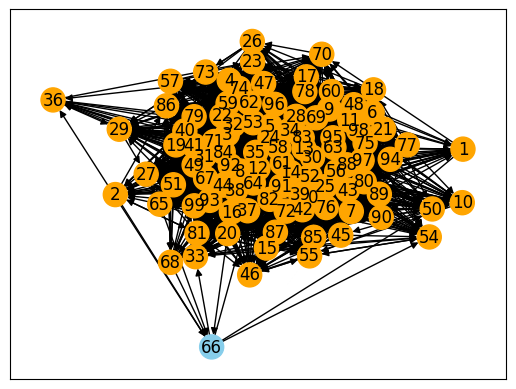

KeyboardInterrupt: 

In [5]:
for G in dataset1:
    nxG = nx.from_numpy_array(G.a,create_using=nx.DiGraph)
    labels = np.argmax(G.y,axis=1)
    plot_graph_dir(nxG,labels)

# Caso 2: dirigido, mismo tamaño, NO balanceado (1a100), clases mezcladas

No dirigido, i.e. matriz de adyacencia simétrica

Todos los grafos del mismo tamaño: 100 nodos

Clases "mezcladas"

In [9]:
class synthetic_Dir_100nodes_NoBalanced_1a100_clasesMezcl(Dataset):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    @property
    def path(self):
        return os.path.join(DATASET_FOLDER, "syntheticGraphs", self.__class__.__name__)
    
    def download(self):
        os.makedirs(self.path)
        
        def generate_synthetic_graph_csbm(n_nodes, n_communities, n_features, edge_prob_matrix, node_feature_means,\
                                  n_infected, semilla, indice, feature_cov_matrix=None):
            # Assign nodes to communities
            np.random.seed(semilla*(indice+1))
            indices = [np.random.randint(0,n_nodes) for i in range(n_infected)]
            communities = np.array([int(j in indices) for j in range(n_nodes)])

            # Generate node features
            if feature_cov_matrix is None:
                feature_cov_matrix = np.eye(n_features)
            features = np.zeros((n_nodes, n_features))
            for k in range(n_communities):
                nodes_in_community = np.where(communities == k)[0]
                features[nodes_in_community] = np.random.multivariate_normal(node_feature_means[k], feature_cov_matrix,\
                                                                             len(nodes_in_community))

            # Compute community membership probabilities based on node features
            community_membership_probs = softmax(features @ node_feature_means.T, axis=1)

            # Generate edges based on community membership probabilities
            adjacency_matrix = np.zeros((n_nodes, n_nodes))
            for i in range(n_nodes):
                for j in range(n_nodes):
                    if i == j:
                        continue
                    community_i = communities[i]
                    community_j = communities[j]
                    edge_prob = edge_prob_matrix[community_i, community_j] * community_membership_probs[i, community_j] * community_membership_probs[j, community_i]
                    adjacency_matrix[i, j] = np.random.binomial(1, edge_prob)

            labels = tf.keras.utils.to_categorical(communities)
            adjacency_matrix = sparse.csr_matrix(adjacency_matrix)
            return Graph(x=features, a=adjacency_matrix, y=labels)

        
        n_graphs = 10
        n_nodes = 100
        n_features = 2
        n_classes = 2
        n_infected = 1
        # Probability matrix for edges between communities
        edge_prob_matrix = np.array([
                                        [0.5, 0.5],
                                        [0.5, 0.5]
                                    ])
        # Node feature means for each community
        node_feature_means = np.array([
                                        [1, 1], #, 0, 0, 0],
                                        [1, 1] #, 0, 0, 0]
                                    ])
        
        semillas = [123, 234, 345, 456, 567, 679, 789, 321, 654, 987]
        
        # Bien separadas las clases:
        graphs1 = [generate_synthetic_graph_csbm(n_nodes, n_classes, n_features, edge_prob_matrix, node_feature_means, n_infected, semillas[i], 0, feature_cov_matrix=None) for i in range(n_graphs)]
        for j in range(10):
            filename = os.path.join(self.path, f'graph_Dir_100nodes_NoBalanced_1a100_clasesMezcl_2{j}.npz')
            np.savez(filename, x=graphs1[j].x, a=graphs1[j].a, y=graphs1[j].y)

        # Free memory
        del graphs1
        gc.collect()


    def read(self):
        # We must return a list of Graph objects
        output = []

        for j in range(10):
            data1 = np.load(os.path.join(self.path, f'graph_Dir_100nodes_NoBalanced_1a100_clasesMezcl_2{j}.npz'), allow_pickle=True)
            output.append(
                Graph(x=data1['x'], a=data1['a'][()], y=data1['y']) # también puede ser a=data['a'].item()
            )

        return output
    
    


In [10]:
dataset2 = synthetic_Dir_100nodes_NoBalanced_1a100_clasesMezcl()

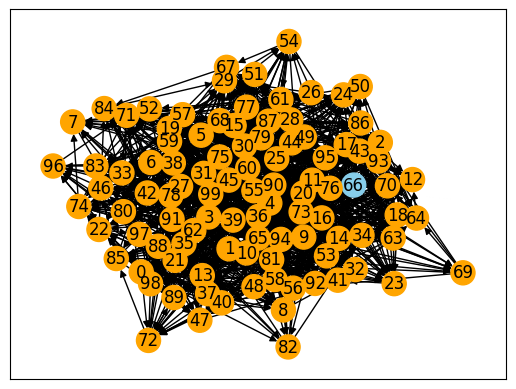

KeyboardInterrupt: 

In [13]:
for G in dataset2:
    nxG = nx.from_numpy_array(G.a,create_using=nx.DiGraph)
    labels = np.argmax(G.y,axis=1)
    plot_graph_dir(nxG,labels)

# Caso 3:  dirigido, mismo tamaño, NO balanceado (2a100), clases separadas

No dirigido, i.e. matriz de adyacencia simétrica

Todos los grafos del mismo tamaño: 100 nodos

Clases "separadas" (a juzgar por la representación gráfica)

In [16]:
class synthetic_Dir_100nodes_NoBalanced_2a100_clasesSep(Dataset):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    @property
    def path(self):
        return os.path.join(DATASET_FOLDER, "syntheticGraphs", self.__class__.__name__)
    
    def download(self):
        os.makedirs(self.path)
        
        def generate_synthetic_graph_csbm(n_nodes, n_communities, n_features, edge_prob_matrix, node_feature_means,\
                                  n_infected, semilla, indice, feature_cov_matrix=None):
            # Assign nodes to communities
            np.random.seed(semilla*(indice+1))
            indices = [np.random.randint(0,n_nodes) for i in range(n_infected)]
            communities = np.array([int(j in indices) for j in range(n_nodes)])

            # Generate node features
            if feature_cov_matrix is None:
                feature_cov_matrix = np.eye(n_features)
            features = np.zeros((n_nodes, n_features))
            for k in range(n_communities):
                nodes_in_community = np.where(communities == k)[0]
                features[nodes_in_community] = np.random.multivariate_normal(node_feature_means[k], feature_cov_matrix,\
                                                                             len(nodes_in_community))

            # Compute community membership probabilities based on node features
            community_membership_probs = softmax(features @ node_feature_means.T, axis=1)

            # Generate edges based on community membership probabilities
            adjacency_matrix = np.zeros((n_nodes, n_nodes))
            for i in range(n_nodes):
                for j in range(n_nodes):
                    if i == j:
                        continue
                    community_i = communities[i]
                    community_j = communities[j]
                    edge_prob = edge_prob_matrix[community_i, community_j] * community_membership_probs[i, community_j] * community_membership_probs[j, community_i]
                    adjacency_matrix[i, j] = np.random.binomial(1, edge_prob)

            labels = tf.keras.utils.to_categorical(communities)
            adjacency_matrix = sparse.csr_matrix(adjacency_matrix)
            return Graph(x=features, a=adjacency_matrix, y=labels)

        
        n_graphs = 10
        n_nodes = 100
        n_features = 2
        n_classes = 2
        n_infected = 2
        # Probability matrix for edges between communities
        edge_prob_matrix = np.array([
                                        [0.8, 0.2],
                                        [0.3, 0.7]
                                    ])
        # Node feature means for each community
        node_feature_means = np.array([
                                        [2, 1], #, 0, 0, 0],
                                        [1, 2] #, 0, 0, 0]
                                    ])
        
        semillas = [123, 234, 345, 456, 567, 679, 789, 321, 654, 987]
        
        # Bien separadas las clases:
        graphs1 = [generate_synthetic_graph_csbm(n_nodes, n_classes, n_features, edge_prob_matrix, node_feature_means, n_infected, semillas[i], 0, feature_cov_matrix=None) for i in range(n_graphs)]
        for j in range(10):
            filename = os.path.join(self.path, f'graph_Dir_100nodes_NoBalanced_2a100_clasesSep_0{j}.npz')
            np.savez(filename, x=graphs1[j].x, a=graphs1[j].a, y=graphs1[j].y)

        # Free memory
        del graphs1
        gc.collect()


    def read(self):
        # We must return a list of Graph objects
        output = []

        for j in range(10):
            data1 = np.load(os.path.join(self.path, f'graph_Dir_100nodes_NoBalanced_2a100_clasesSep_0{j}.npz'), allow_pickle=True)
            output.append(
                Graph(x=data1['x'], a=data1['a'][()], y=data1['y']) # también puede ser a=data['a'].item()
            )

        return output
    
    


In [17]:
dataset3 = synthetic_Dir_100nodes_NoBalanced_2a100_clasesSep()

# Caso 4: dirigido, mismo tamaño, NO balanceado (2a100), clases mezcladas

No dirigido, i.e. matriz de adyacencia simétrica

Todos los grafos del mismo tamaño: 100 nodos

Clases "mezcladas"

In [20]:
class synthetic_Dir_100nodes_NoBalanced_2a100_clasesMezcl(Dataset):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    @property
    def path(self):
        return os.path.join(DATASET_FOLDER, "syntheticGraphs", self.__class__.__name__)
    
    def download(self):
        os.makedirs(self.path)
        
        def generate_synthetic_graph_csbm(n_nodes, n_communities, n_features, edge_prob_matrix, node_feature_means,\
                                  n_infected, semilla, indice, feature_cov_matrix=None):
            # Assign nodes to communities
            np.random.seed(semilla*(indice+1))
            indices = [np.random.randint(0,n_nodes) for i in range(n_infected)]
            communities = np.array([int(j in indices) for j in range(n_nodes)])

            # Generate node features
            if feature_cov_matrix is None:
                feature_cov_matrix = np.eye(n_features)
            features = np.zeros((n_nodes, n_features))
            for k in range(n_communities):
                nodes_in_community = np.where(communities == k)[0]
                features[nodes_in_community] = np.random.multivariate_normal(node_feature_means[k], feature_cov_matrix,\
                                                                             len(nodes_in_community))

            # Compute community membership probabilities based on node features
            community_membership_probs = softmax(features @ node_feature_means.T, axis=1)

            # Generate edges based on community membership probabilities
            adjacency_matrix = np.zeros((n_nodes, n_nodes))
            for i in range(n_nodes):
                for j in range(n_nodes):
                    if i == j:
                        continue
                    community_i = communities[i]
                    community_j = communities[j]
                    edge_prob = edge_prob_matrix[community_i, community_j] * community_membership_probs[i, community_j] * community_membership_probs[j, community_i]
                    adjacency_matrix[i, j] = np.random.binomial(1, edge_prob)

            labels = tf.keras.utils.to_categorical(communities)
            adjacency_matrix = sparse.csr_matrix(adjacency_matrix)
            return Graph(x=features, a=adjacency_matrix, y=labels)

        
        n_graphs = 10
        n_nodes = 100
        n_features = 2
        n_classes = 2
        n_infected = 2
        # Probability matrix for edges between communities
        edge_prob_matrix = np.array([
                                    [0.5, 0.5],
                                    [0.5, 0.5]
                            ])
        # Node feature means for each community
        node_feature_means = np.array([
                                        [1, 1], #, 0, 0, 0],
                                        [1, 1] #, 0, 0, 0]
                                    ])
        
        semillas = [123, 234, 345, 456, 567, 678, 789, 321, 654, 987]
        
        # Clases un poco más juntas:
        graphs2 = [generate_synthetic_graph_csbm(n_nodes, n_classes, n_features, edge_prob_matrix, node_feature_means, n_infected, semillas[i], 1, feature_cov_matrix=None) for i in range(n_graphs)]
        for j in range(10):
            filename = os.path.join(self.path, f'graph_Dir_100nodes_NoBalanced_2a100_clasesMezcl_2{j}.npz')
            np.savez(filename, x=graphs2[j].x, a=graphs2[j].a, y=graphs2[j].y)

        # Free memory
        del graphs2
        gc.collect()


    def read(self):
        # We must return a list of Graph objects
        output = []

        for j in range(10):
            data2 = np.load(os.path.join(self.path, f'graph_Dir_100nodes_NoBalanced_2a100_clasesMezcl_2{j}.npz'), allow_pickle=True)
            output.append(
                Graph(x=data2['x'], a=data2['a'][()], y=data2['y']) # también puede ser a=data['a'].item()
            )

        return output
    
    


In [21]:
dataset4 = synthetic_Dir_100nodes_NoBalanced_2a100_clasesMezcl()

# Caso 5: dirigido, mismo tamaño, NO balanceado (5a100), clases separadas

No dirigido, i.e. matriz de adyacencia simétrica

Todos los grafos del mismo tamaño: 100 nodos

Clases "separadas" (a juzgar por la representación gráfica)

In [24]:
class synthetic_Dir_100nodes_NoBalanced_5a100_clasesSep(Dataset):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    @property
    def path(self):
        return os.path.join(DATASET_FOLDER, "syntheticGraphs", self.__class__.__name__)
    
    def download(self):
        os.makedirs(self.path)
        
        def generate_synthetic_graph_csbm(n_nodes, n_communities, n_features, edge_prob_matrix, node_feature_means,\
                                  n_infected, semilla, indice, feature_cov_matrix=None):
            # Assign nodes to communities
            np.random.seed(semilla*(indice+1))
            indices = [np.random.randint(0,n_nodes) for i in range(n_infected)]
            communities = np.array([int(j in indices) for j in range(n_nodes)])

            # Generate node features
            if feature_cov_matrix is None:
                feature_cov_matrix = np.eye(n_features)
            features = np.zeros((n_nodes, n_features))
            for k in range(n_communities):
                nodes_in_community = np.where(communities == k)[0]
                features[nodes_in_community] = np.random.multivariate_normal(node_feature_means[k], feature_cov_matrix,\
                                                                             len(nodes_in_community))

            # Compute community membership probabilities based on node features
            community_membership_probs = softmax(features @ node_feature_means.T, axis=1)

            # Generate edges based on community membership probabilities
            adjacency_matrix = np.zeros((n_nodes, n_nodes))
            for i in range(n_nodes):
                for j in range(n_nodes):
                    if i == j:
                        continue
                    community_i = communities[i]
                    community_j = communities[j]
                    edge_prob = edge_prob_matrix[community_i, community_j] * community_membership_probs[i, community_j] * community_membership_probs[j, community_i]
                    adjacency_matrix[i, j] = np.random.binomial(1, edge_prob)

            labels = tf.keras.utils.to_categorical(communities)
            adjacency_matrix = sparse.csr_matrix(adjacency_matrix)
            return Graph(x=features, a=adjacency_matrix, y=labels)

        
        n_graphs = 10
        n_nodes = 100
        n_features = 2
        n_classes = 2
        n_infected = 5
        # Probability matrix for edges between communities
        edge_prob_matrix = np.array([
                                        [0.8, 0.2],
                                        [0.3, 0.7]
                                    ])
        # Node feature means for each community
        node_feature_means = np.array([
                                        [2, 1], #, 0, 0, 0],
                                        [1, 2] #, 0, 0, 0]
                                    ])
        
        semillas = [123, 234, 345, 456, 567, 679, 789, 321, 654, 987]
        
        # Bien separadas las clases:
        graphs1 = [generate_synthetic_graph_csbm(n_nodes, n_classes, n_features, edge_prob_matrix, node_feature_means, n_infected, semillas[i], 0, feature_cov_matrix=None) for i in range(n_graphs)]
        for j in range(10):
            filename = os.path.join(self.path, f'graph_Dir_100nodes_NoBalanced_5a100_clasesSep_0{j}.npz')
            np.savez(filename, x=graphs1[j].x, a=graphs1[j].a, y=graphs1[j].y)

        # Free memory
        del graphs1
        gc.collect()


    def read(self):
        # We must return a list of Graph objects
        output = []

        for j in range(10):
            data1 = np.load(os.path.join(self.path, f'graph_Dir_100nodes_NoBalanced_5a100_clasesSep_0{j}.npz'), allow_pickle=True)
            output.append(
                Graph(x=data1['x'], a=data1['a'][()], y=data1['y']) # también puede ser a=data['a'].item()
            )

        return output
    
    


In [25]:
dataset5 = synthetic_Dir_100nodes_NoBalanced_5a100_clasesSep()

# Caso 6: dirigido, mismo tamaño, NO balanceado (5a100), clases mezcladas

No dirigido, i.e. matriz de adyacencia simétrica

Todos los grafos del mismo tamaño: 100 nodos

Clases "mezcladas" (a juzgar por la representación gráfica)

In [28]:
class synthetic_Dir_100nodes_NoBalanced_5a100_clasesMezcl(Dataset):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    @property
    def path(self):
        return os.path.join(DATASET_FOLDER, "syntheticGraphs", self.__class__.__name__)
    
    def download(self):
        os.makedirs(self.path)
        
        def generate_synthetic_graph_csbm(n_nodes, n_communities, n_features, edge_prob_matrix, node_feature_means,\
                                  n_infected, semilla, indice, feature_cov_matrix=None):
            # Assign nodes to communities
            np.random.seed(semilla*(indice+1))
            indices = [np.random.randint(0,n_nodes) for i in range(n_infected)]
            communities = np.array([int(j in indices) for j in range(n_nodes)])

            # Generate node features
            if feature_cov_matrix is None:
                feature_cov_matrix = np.eye(n_features)
            features = np.zeros((n_nodes, n_features))
            for k in range(n_communities):
                nodes_in_community = np.where(communities == k)[0]
                features[nodes_in_community] = np.random.multivariate_normal(node_feature_means[k], feature_cov_matrix,\
                                                                             len(nodes_in_community))

            # Compute community membership probabilities based on node features
            community_membership_probs = softmax(features @ node_feature_means.T, axis=1)

            # Generate edges based on community membership probabilities
            adjacency_matrix = np.zeros((n_nodes, n_nodes))
            for i in range(n_nodes):
                for j in range(n_nodes):
                    if i == j:
                        continue
                    community_i = communities[i]
                    community_j = communities[j]
                    edge_prob = edge_prob_matrix[community_i, community_j] * community_membership_probs[i, community_j] * community_membership_probs[j, community_i]
                    adjacency_matrix[i, j] = np.random.binomial(1, edge_prob)

            labels = tf.keras.utils.to_categorical(communities)
            adjacency_matrix = sparse.csr_matrix(adjacency_matrix)
            return Graph(x=features, a=adjacency_matrix, y=labels)

        
        n_graphs = 10
        n_nodes = 100
        n_features = 2
        n_classes = 2
        n_infected = 5
        # Probability matrix for edges between communities
        edge_prob_matrix = np.array([
                                    [0.5, 0.5],
                                    [0.5, 0.5]
                            ])
        # Node feature means for each community
        node_feature_means = np.array([
                                        [1, 1], #, 0, 0, 0],
                                        [1, 1] #, 0, 0, 0]
                                    ])
        
        semillas = [123, 234, 345, 456, 567, 678, 789, 321, 654, 987]
        
        # Clases un poco más juntas:
        graphs2 = [generate_synthetic_graph_csbm(n_nodes, n_classes, n_features, edge_prob_matrix, node_feature_means, n_infected, semillas[i], 1, feature_cov_matrix=None) for i in range(n_graphs)]
        for j in range(10):
            filename = os.path.join(self.path, f'graph_Dir_100nodes_NoBalanced_5a100_clasesMezcl_2{j}.npz')
            np.savez(filename, x=graphs2[j].x, a=graphs2[j].a, y=graphs2[j].y)

        # Free memory
        del graphs2
        gc.collect()


    def read(self):
        # We must return a list of Graph objects
        output = []

        for j in range(10):
            data2 = np.load(os.path.join(self.path, f'graph_Dir_100nodes_NoBalanced_5a100_clasesMezcl_2{j}.npz'), allow_pickle=True)
            output.append(
                Graph(x=data2['x'], a=data2['a'][()], y=data2['y']) # también puede ser a=data['a'].item()
            )

        return output
    
    


In [29]:
dataset6 = synthetic_Dir_100nodes_NoBalanced_5a100_clasesMezcl()

# Caso 7: dirigido, mismo tamaño, NO balanceado (10a100), clases separadas

No dirigido, i.e. matriz de adyacencia simétrica

Todos los grafos del mismo tamaño: 100 nodos

Clases "separadas" (a juzgar por la representación gráfica)

In [32]:
class synthetic_Dir_100nodes_NoBalanced_10a100_clasesSep(Dataset):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    @property
    def path(self):
        return os.path.join(DATASET_FOLDER, "syntheticGraphs", self.__class__.__name__)
    
    def download(self):
        os.makedirs(self.path)
        
        def generate_synthetic_graph_csbm(n_nodes, n_communities, n_features, edge_prob_matrix, node_feature_means,\
                                  n_infected, semilla, indice, feature_cov_matrix=None):
            # Assign nodes to communities
            np.random.seed(semilla*(indice+1))
            indices = [np.random.randint(0,n_nodes) for i in range(n_infected)]
            communities = np.array([int(j in indices) for j in range(n_nodes)])

            # Generate node features
            if feature_cov_matrix is None:
                feature_cov_matrix = np.eye(n_features)
            features = np.zeros((n_nodes, n_features))
            for k in range(n_communities):
                nodes_in_community = np.where(communities == k)[0]
                features[nodes_in_community] = np.random.multivariate_normal(node_feature_means[k], feature_cov_matrix,\
                                                                             len(nodes_in_community))

            # Compute community membership probabilities based on node features
            community_membership_probs = softmax(features @ node_feature_means.T, axis=1)

            # Generate edges based on community membership probabilities
            adjacency_matrix = np.zeros((n_nodes, n_nodes))
            for i in range(n_nodes):
                for j in range(n_nodes):
                    if i == j:
                        continue
                    community_i = communities[i]
                    community_j = communities[j]
                    edge_prob = edge_prob_matrix[community_i, community_j] * community_membership_probs[i, community_j] * community_membership_probs[j, community_i]
                    adjacency_matrix[i, j] = np.random.binomial(1, edge_prob)

            labels = tf.keras.utils.to_categorical(communities)
            adjacency_matrix = sparse.csr_matrix(adjacency_matrix)
            return Graph(x=features, a=adjacency_matrix, y=labels)

        
        n_graphs = 10
        n_nodes = 100
        n_features = 2
        n_classes = 2
        n_infected = 10
        # Probability matrix for edges between communities
        edge_prob_matrix = np.array([
                                        [0.8, 0.2],
                                        [0.3, 0.7]
                                    ])
        # Node feature means for each community
        node_feature_means = np.array([
                                        [2, 1], #, 0, 0, 0],
                                        [1, 2] #, 0, 0, 0]
                                    ])
        
        semillas = [123, 234, 345, 456, 567, 679, 789, 321, 654, 987]
        
        # Bien separadas las clases:
        graphs1 = [generate_synthetic_graph_csbm(n_nodes, n_classes, n_features, edge_prob_matrix, node_feature_means, n_infected, semillas[i], 0, feature_cov_matrix=None) for i in range(n_graphs)]
        for j in range(10):
            filename = os.path.join(self.path, f'graph_Dir_100nodes_NoBalanced_10a100_clasesSep_0{j}.npz')
            np.savez(filename, x=graphs1[j].x, a=graphs1[j].a, y=graphs1[j].y)

        # Free memory
        del graphs1
        gc.collect()


    def read(self):
        # We must return a list of Graph objects
        output = []

        for j in range(10):
            data1 = np.load(os.path.join(self.path, f'graph_Dir_100nodes_NoBalanced_10a100_clasesSep_0{j}.npz'), allow_pickle=True)
            output.append(
                Graph(x=data1['x'], a=data1['a'][()], y=data1['y']) # también puede ser a=data['a'].item()
            )

        return output
    
    


In [33]:
dataset7 = synthetic_Dir_100nodes_NoBalanced_10a100_clasesSep()

# Caso 8: dirigido, mismo tamaño, NO balanceado (10a100), clases mezcladas

No dirigido, i.e. matriz de adyacencia simétrica

Todos los grafos del mismo tamaño: 100 nodos

Clases "mezcladas"

In [37]:
class synthetic_Dir_100nodes_NoBalanced_10a100_clasesMezcl(Dataset):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    @property
    def path(self):
        return os.path.join(DATASET_FOLDER, "syntheticGraphs", self.__class__.__name__)
    
    def download(self):
        os.makedirs(self.path)
        
        def generate_synthetic_graph_csbm(n_nodes, n_communities, n_features, edge_prob_matrix, node_feature_means,\
                                  n_infected, semilla, indice, feature_cov_matrix=None):
            # Assign nodes to communities
            np.random.seed(semilla*(indice+1))
            indices = [np.random.randint(0,n_nodes) for i in range(n_infected)]
            communities = np.array([int(j in indices) for j in range(n_nodes)])

            # Generate node features
            if feature_cov_matrix is None:
                feature_cov_matrix = np.eye(n_features)
            features = np.zeros((n_nodes, n_features))
            for k in range(n_communities):
                nodes_in_community = np.where(communities == k)[0]
                features[nodes_in_community] = np.random.multivariate_normal(node_feature_means[k], feature_cov_matrix,\
                                                                             len(nodes_in_community))

            # Compute community membership probabilities based on node features
            community_membership_probs = softmax(features @ node_feature_means.T, axis=1)

            # Generate edges based on community membership probabilities
            adjacency_matrix = np.zeros((n_nodes, n_nodes))
            for i in range(n_nodes):
                for j in range(n_nodes):
                    if i == j:
                        continue
                    community_i = communities[i]
                    community_j = communities[j]
                    edge_prob = edge_prob_matrix[community_i, community_j] * community_membership_probs[i, community_j] * community_membership_probs[j, community_i]
                    adjacency_matrix[i, j] = np.random.binomial(1, edge_prob)

            labels = tf.keras.utils.to_categorical(communities)
            adjacency_matrix = sparse.csr_matrix(adjacency_matrix)
            return Graph(x=features, a=adjacency_matrix, y=labels)

        
        n_graphs = 10
        n_nodes = 100
        n_features = 2
        n_classes = 2
        n_infected = 10
        # Probability matrix for edges between communities
        edge_prob_matrix = np.array([
                                    [0.5, 0.5],
                                    [0.5, 0.5]
                            ])
        # Node feature means for each community
        node_feature_means = np.array([
                                        [1, 1], #, 0, 0, 0],
                                        [1, 1] #, 0, 0, 0]
                                    ])
        
        semillas = [123, 234, 345, 456, 567, 678, 789, 321, 654, 987]
        
        # Clases un poco más juntas:
        graphs2 = [generate_synthetic_graph_csbm(n_nodes, n_classes, n_features, edge_prob_matrix, node_feature_means, n_infected, semillas[i], 1, feature_cov_matrix=None) for i in range(n_graphs)]
        for j in range(10):
            filename = os.path.join(self.path, f'graph_Dir_100nodes_NoBalanced_10a100_clasesMezcl_2{j}.npz')
            np.savez(filename, x=graphs2[j].x, a=graphs2[j].a, y=graphs2[j].y)

        # Free memory
        del graphs2
        gc.collect()


    def read(self):
        # We must return a list of Graph objects
        output = []

        for j in range(10):
            data2 = np.load(os.path.join(self.path, f'graph_Dir_100nodes_NoBalanced_10a100_clasesMezcl_2{j}.npz'), allow_pickle=True)
            output.append(
                Graph(x=data2['x'], a=data2['a'][()], y=data2['y']) # también puede ser a=data['a'].item()
            )

        return output
    
    


In [38]:
dataset8 = synthetic_Dir_100nodes_NoBalanced_10a100_clasesMezcl()

# Caso 9: dirigido, mismo tamaño, NO balanceado (20a100), clases separadas

No dirigido, i.e. matriz de adyacencia simétrica

Todos los grafos del mismo tamaño: 100 nodos

Clases "separadas" 

In [41]:
class synthetic_Dir_100nodes_NoBalanced_20a100_clasesSep(Dataset):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    @property
    def path(self):
        return os.path.join(DATASET_FOLDER, "syntheticGraphs", self.__class__.__name__)
    
    def download(self):
        os.makedirs(self.path)
        
        def generate_synthetic_graph_csbm(n_nodes, n_communities, n_features, edge_prob_matrix, node_feature_means,\
                                  n_infected, semilla, indice, feature_cov_matrix=None):
            # Assign nodes to communities
            np.random.seed(semilla*(indice+1))
            indices = [np.random.randint(0,n_nodes) for i in range(n_infected)]
            communities = np.array([int(j in indices) for j in range(n_nodes)])

            # Generate node features
            if feature_cov_matrix is None:
                feature_cov_matrix = np.eye(n_features)
            features = np.zeros((n_nodes, n_features))
            for k in range(n_communities):
                nodes_in_community = np.where(communities == k)[0]
                features[nodes_in_community] = np.random.multivariate_normal(node_feature_means[k], feature_cov_matrix,\
                                                                             len(nodes_in_community))

            # Compute community membership probabilities based on node features
            community_membership_probs = softmax(features @ node_feature_means.T, axis=1)

            # Generate edges based on community membership probabilities
            adjacency_matrix = np.zeros((n_nodes, n_nodes))
            for i in range(n_nodes):
                for j in range(n_nodes):
                    if i == j:
                        continue
                    community_i = communities[i]
                    community_j = communities[j]
                    edge_prob = edge_prob_matrix[community_i, community_j] * community_membership_probs[i, community_j] * community_membership_probs[j, community_i]
                    adjacency_matrix[i, j] = np.random.binomial(1, edge_prob)

            labels = tf.keras.utils.to_categorical(communities)
            adjacency_matrix = sparse.csr_matrix(adjacency_matrix)
            return Graph(x=features, a=adjacency_matrix, y=labels)

        
        n_graphs = 10
        n_nodes = 100
        n_features = 2
        n_classes = 2
        n_infected = 20
        # Probability matrix for edges between communities
        edge_prob_matrix = np.array([
                                        [0.8, 0.2],
                                        [0.3, 0.7]
                                    ])
        # Node feature means for each community
        node_feature_means = np.array([
                                        [2, 1], #, 0, 0, 0],
                                        [1, 2] #, 0, 0, 0]
                                    ])
        
        semillas = [123, 234, 345, 456, 567, 679, 789, 321, 654, 987]
        
        # Bien separadas las clases:
        graphs1 = [generate_synthetic_graph_csbm(n_nodes, n_classes, n_features, edge_prob_matrix, node_feature_means, n_infected, semillas[i], 0, feature_cov_matrix=None) for i in range(n_graphs)]
        for j in range(10):
            filename = os.path.join(self.path, f'graph_Dir_100nodes_NoBalanced_20a100_clasesSep_0{j}.npz')
            np.savez(filename, x=graphs1[j].x, a=graphs1[j].a, y=graphs1[j].y)

        # Free memory
        del graphs1
        gc.collect()


    def read(self):
        # We must return a list of Graph objects
        output = []

        for j in range(10):
            data1 = np.load(os.path.join(self.path, f'graph_Dir_100nodes_NoBalanced_20a100_clasesSep_0{j}.npz'), allow_pickle=True)
            output.append(
                Graph(x=data1['x'], a=data1['a'][()], y=data1['y']) # también puede ser a=data['a'].item()
            )

        return output
    
    


In [42]:
dataset9 = synthetic_Dir_100nodes_NoBalanced_20a100_clasesSep()

# Caso 10: dirigido, mismo tamaño, NO balanceado (20a100), clases mezcladas

No dirigido, i.e. matriz de adyacencia simétrica

Todos los grafos del mismo tamaño: 100 nodos

Clases "mezcladas"

In [45]:
class synthetic_Dir_100nodes_NoBalanced_20a100_clasesMezcl(Dataset):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    @property
    def path(self):
        return os.path.join(DATASET_FOLDER, "syntheticGraphs", self.__class__.__name__)
    
    def download(self):
        os.makedirs(self.path)
        
        def generate_synthetic_graph_csbm(n_nodes, n_communities, n_features, edge_prob_matrix, node_feature_means,\
                                  n_infected, semilla, indice, feature_cov_matrix=None):
            # Assign nodes to communities
            np.random.seed(semilla*(indice+1))
            indices = [np.random.randint(0,n_nodes) for i in range(n_infected)]
            communities = np.array([int(j in indices) for j in range(n_nodes)])

            # Generate node features
            if feature_cov_matrix is None:
                feature_cov_matrix = np.eye(n_features)
            features = np.zeros((n_nodes, n_features))
            for k in range(n_communities):
                nodes_in_community = np.where(communities == k)[0]
                features[nodes_in_community] = np.random.multivariate_normal(node_feature_means[k], feature_cov_matrix,\
                                                                             len(nodes_in_community))

            # Compute community membership probabilities based on node features
            community_membership_probs = softmax(features @ node_feature_means.T, axis=1)

            # Generate edges based on community membership probabilities
            adjacency_matrix = np.zeros((n_nodes, n_nodes))
            for i in range(n_nodes):
                for j in range(n_nodes):
                    if i == j:
                        continue
                    community_i = communities[i]
                    community_j = communities[j]
                    edge_prob = edge_prob_matrix[community_i, community_j] * community_membership_probs[i, community_j] * community_membership_probs[j, community_i]
                    adjacency_matrix[i, j] = np.random.binomial(1, edge_prob)

            labels = tf.keras.utils.to_categorical(communities)
            adjacency_matrix = sparse.csr_matrix(adjacency_matrix)
            return Graph(x=features, a=adjacency_matrix, y=labels)

        
        n_graphs = 10
        n_nodes = 100
        n_features = 2
        n_classes = 2
        n_infected = 20
        # Probability matrix for edges between communities
        edge_prob_matrix = np.array([
                                    [0.5, 0.5],
                                    [0.5, 0.5]
                            ])
        # Node feature means for each community
        node_feature_means = np.array([
                                        [1, 1], #, 0, 0, 0],
                                        [1, 1] #, 0, 0, 0]
                                    ])
        
        semillas = [123, 234, 345, 456, 567, 678, 789, 321, 654, 987]
        
        # Clases un poco más juntas:
        graphs2 = [generate_synthetic_graph_csbm(n_nodes, n_classes, n_features, edge_prob_matrix, node_feature_means, n_infected, semillas[i], 1, feature_cov_matrix=None) for i in range(n_graphs)]
        for j in range(10):
            filename = os.path.join(self.path, f'graph_Dir_100nodes_NoBalanced_20a100_clasesMezcl_2{j}.npz')
            np.savez(filename, x=graphs2[j].x, a=graphs2[j].a, y=graphs2[j].y)

        # Free memory
        del graphs2
        gc.collect()


    def read(self):
        # We must return a list of Graph objects
        output = []

        for j in range(10):
            data2 = np.load(os.path.join(self.path, f'graph_Dir_100nodes_NoBalanced_20a100_clasesMezcl_2{j}.npz'), allow_pickle=True)
            output.append(
                Graph(x=data2['x'], a=data2['a'][()], y=data2['y']) # también puede ser a=data['a'].item()
            )

        return output
    
    


In [46]:
dataset10 = synthetic_Dir_100nodes_NoBalanced_20a100_clasesMezcl()

# Caso 11: dirigido, mismo tamaño, NO balanceado (1a100), clases separadas, features aplanadas

Grafos iguales a los del caso 1, salvo que las features están aplanadas a 1

In [49]:
class synthetic_Dir_100nodes_NoBalanced_1a100_clasesSep_flattened(Dataset):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    @property
    def path(self):
        return os.path.join(DATASET_FOLDER, "syntheticGraphs", self.__class__.__name__)
    
    def download(self):
        os.makedirs(self.path)
        
        def generate_synthetic_graph_csbm(n_nodes, n_communities, n_features, edge_prob_matrix, node_feature_means,\
                                  n_infected, semilla, indice, feature_cov_matrix=None):
            # Assign nodes to communities
            np.random.seed(semilla*(indice+1))
            indices = [np.random.randint(0,n_nodes) for i in range(n_infected)]
            communities = np.array([int(j in indices) for j in range(n_nodes)])

            # Generate node features
            if feature_cov_matrix is None:
                feature_cov_matrix = np.eye(n_features)
            features = np.zeros((n_nodes, n_features))
            for k in range(n_communities):
                nodes_in_community = np.where(communities == k)[0]
                features[nodes_in_community] = np.random.multivariate_normal(node_feature_means[k], feature_cov_matrix,\
                                                                             len(nodes_in_community))

            # Compute community membership probabilities based on node features
            community_membership_probs = softmax(features @ node_feature_means.T, axis=1)

            # Generate edges based on community membership probabilities
            adjacency_matrix = np.zeros((n_nodes, n_nodes))
            for i in range(n_nodes):
                for j in range(n_nodes):
                    if i == j:
                        continue
                    community_i = communities[i]
                    community_j = communities[j]
                    edge_prob = edge_prob_matrix[community_i, community_j] * community_membership_probs[i, community_j] * community_membership_probs[j, community_i]
                    adjacency_matrix[i, j] = np.random.binomial(1, edge_prob)

            labels = tf.keras.utils.to_categorical(communities)
            adjacency_matrix = sparse.csr_matrix(adjacency_matrix)
            return Graph(x=np.ones((n_nodes, n_features)), a=adjacency_matrix, y=labels)

        
        n_graphs = 10
        n_nodes = 100
        n_features = 2
        n_classes = 2
        n_infected = 1
        # Probability matrix for edges between communities
        edge_prob_matrix = np.array([
                                        [0.8, 0.2],
                                        [0.3, 0.7]
                                    ])
        # Node feature means for each community
        node_feature_means = np.array([
                                        [2, 1], #, 0, 0, 0],
                                        [1, 2] #, 0, 0, 0]
                                    ])
        
        semillas = [123, 234, 345, 456, 567, 679, 789, 321, 654, 987]
        
        # Bien separadas las clases:
        graphs1 = [generate_synthetic_graph_csbm(n_nodes, n_classes, n_features, edge_prob_matrix, node_feature_means, n_infected, semillas[i], 0, feature_cov_matrix=None) for i in range(n_graphs)]
        for j in range(10):
            filename = os.path.join(self.path, f'graph_Dir_100nodes_NoBalanced_1a100_clasesSep_0{j}_flattened.npz')
            np.savez(filename, x=np.ones((n_nodes, n_features)), a=graphs1[j].a, y=graphs1[j].y)

        # Free memory
        del graphs1
        gc.collect()


    def read(self):
        # We must return a list of Graph objects
        output = []

        for j in range(10):
            data1 = np.load(os.path.join(self.path, f'graph_Dir_100nodes_NoBalanced_1a100_clasesSep_0{j}_flattened.npz'), allow_pickle=True)
            output.append(
                Graph(x=data1['x'], a=data1['a'][()], y=data1['y']) # también puede ser a=data['a'].item()
            )

        return output
    
    


In [50]:
dataset11 = synthetic_Dir_100nodes_NoBalanced_1a100_clasesSep_flattened()

# Caso 12: dirigido, mismo tamaño, NO balanceado (1a100), clases mezcladas, features aplanadas

Grafos iguales a los del caso 2, salvo que las features están aplanadas a 1

In [53]:
class synthetic_Dir_100nodes_NoBalanced_1a100_clasesMezcl_flattened(Dataset):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    @property
    def path(self):
        return os.path.join(DATASET_FOLDER, "syntheticGraphs", self.__class__.__name__)
    
    def download(self):
        os.makedirs(self.path)
        
        def generate_synthetic_graph_csbm(n_nodes, n_communities, n_features, edge_prob_matrix, node_feature_means,\
                                  n_infected, semilla, indice, feature_cov_matrix=None):
            # Assign nodes to communities
            np.random.seed(semilla*(indice+1))
            indices = [np.random.randint(0,n_nodes) for i in range(n_infected)]
            communities = np.array([int(j in indices) for j in range(n_nodes)])

            # Generate node features
            if feature_cov_matrix is None:
                feature_cov_matrix = np.eye(n_features)
            features = np.zeros((n_nodes, n_features))
            for k in range(n_communities):
                nodes_in_community = np.where(communities == k)[0]
                features[nodes_in_community] = np.random.multivariate_normal(node_feature_means[k], feature_cov_matrix,\
                                                                             len(nodes_in_community))

            # Compute community membership probabilities based on node features
            community_membership_probs = softmax(features @ node_feature_means.T, axis=1)

            # Generate edges based on community membership probabilities
            adjacency_matrix = np.zeros((n_nodes, n_nodes))
            for i in range(n_nodes):
                for j in range(n_nodes):
                    if i == j:
                        continue
                    community_i = communities[i]
                    community_j = communities[j]
                    edge_prob = edge_prob_matrix[community_i, community_j] * community_membership_probs[i, community_j] * community_membership_probs[j, community_i]
                    adjacency_matrix[i, j] = np.random.binomial(1, edge_prob)

            labels = tf.keras.utils.to_categorical(communities)
            adjacency_matrix = sparse.csr_matrix(adjacency_matrix)
            return Graph(x=np.ones((n_nodes, n_features)), a=adjacency_matrix, y=labels)

        
        n_graphs = 10
        n_nodes = 100
        n_features = 2
        n_classes = 2
        n_infected = 1
        # Probability matrix for edges between communities
        edge_prob_matrix = np.array([
                                        [0.5, 0.5],
                                        [0.5, 0.5]
                                    ])
        # Node feature means for each community
        node_feature_means = np.array([
                                        [1, 1], #, 0, 0, 0],
                                        [1, 1] #, 0, 0, 0]
                                    ])
        
        semillas = [123, 234, 345, 456, 567, 679, 789, 321, 654, 987]
        
        # Bien separadas las clases:
        graphs1 = [generate_synthetic_graph_csbm(n_nodes, n_classes, n_features, edge_prob_matrix, node_feature_means, n_infected, semillas[i], 0, feature_cov_matrix=None) for i in range(n_graphs)]
        for j in range(10):
            filename = os.path.join(self.path, f'graph_Dir_100nodes_NoBalanced_1a100_clasesMezcl_2{j}_flattened.npz')
            np.savez(filename, x=np.ones((n_nodes, n_features)), a=graphs1[j].a, y=graphs1[j].y)

        # Free memory
        del graphs1
        gc.collect()


    def read(self):
        # We must return a list of Graph objects
        output = []

        for j in range(10):
            data1 = np.load(os.path.join(self.path, f'graph_Dir_100nodes_NoBalanced_1a100_clasesMezcl_2{j}_flattened.npz'), allow_pickle=True)
            output.append(
                Graph(x=data1['x'], a=data1['a'][()], y=data1['y']) # también puede ser a=data['a'].item()
            )

        return output
    
    


In [54]:
dataset12 = synthetic_Dir_100nodes_NoBalanced_1a100_clasesMezcl_flattened()

# Caso 13: dirigido, mismo tamaño, NO balanceado (2a100), clases separadas, features aplanadas

Grafos iguales a los del caso 3, salvo que las features están aplanadas a 1

In [57]:
class synthetic_Dir_100nodes_NoBalanced_2a100_clasesSep_flattened(Dataset):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    @property
    def path(self):
        return os.path.join(DATASET_FOLDER, "syntheticGraphs", self.__class__.__name__)
    
    def download(self):
        os.makedirs(self.path)
        
        def generate_synthetic_graph_csbm(n_nodes, n_communities, n_features, edge_prob_matrix, node_feature_means,\
                                  n_infected, semilla, indice, feature_cov_matrix=None):
            # Assign nodes to communities
            np.random.seed(semilla*(indice+1))
            indices = [np.random.randint(0,n_nodes) for i in range(n_infected)]
            communities = np.array([int(j in indices) for j in range(n_nodes)])

            # Generate node features
            if feature_cov_matrix is None:
                feature_cov_matrix = np.eye(n_features)
            features = np.zeros((n_nodes, n_features))
            for k in range(n_communities):
                nodes_in_community = np.where(communities == k)[0]
                features[nodes_in_community] = np.random.multivariate_normal(node_feature_means[k], feature_cov_matrix,\
                                                                             len(nodes_in_community))

            # Compute community membership probabilities based on node features
            community_membership_probs = softmax(features @ node_feature_means.T, axis=1)

            # Generate edges based on community membership probabilities
            adjacency_matrix = np.zeros((n_nodes, n_nodes))
            for i in range(n_nodes):
                for j in range(n_nodes):
                    if i == j:
                        continue
                    community_i = communities[i]
                    community_j = communities[j]
                    edge_prob = edge_prob_matrix[community_i, community_j] * community_membership_probs[i, community_j] * community_membership_probs[j, community_i]
                    adjacency_matrix[i, j] = np.random.binomial(1, edge_prob)

            labels = tf.keras.utils.to_categorical(communities)
            adjacency_matrix = sparse.csr_matrix(adjacency_matrix)
            return Graph(x=np.ones((n_nodes, n_features)), a=adjacency_matrix, y=labels)

        
        n_graphs = 10
        n_nodes = 100
        n_features = 2
        n_classes = 2
        n_infected = 2
        # Probability matrix for edges between communities
        edge_prob_matrix = np.array([
                                        [0.8, 0.2],
                                        [0.3, 0.7]
                                    ])
        # Node feature means for each community
        node_feature_means = np.array([
                                        [2, 1], #, 0, 0, 0],
                                        [1, 2] #, 0, 0, 0]
                                    ])
        
        semillas = [123, 234, 345, 456, 567, 678, 789, 321, 654, 987]
        
        # Bien separadas las clases:
        graphs1 = [generate_synthetic_graph_csbm(n_nodes, n_classes, n_features, edge_prob_matrix, node_feature_means, n_infected, semillas[i], 0, feature_cov_matrix=None) for i in range(n_graphs)]
        for j in range(10):
            filename = os.path.join(self.path, f'graph_Dir_100nodes_NoBalanced_2a100_clasesSep_0{j}_flattened.npz')
            np.savez(filename, x=graphs1[j].x, a=graphs1[j].a, y=graphs1[j].y)

        # Free memory
        del graphs1
        gc.collect()


    def read(self):
        # We must return a list of Graph objects
        output = []

        for j in range(10):
            data1 = np.load(os.path.join(self.path, f'graph_Dir_100nodes_NoBalanced_2a100_clasesSep_0{j}_flattened.npz'), allow_pickle=True)
            output.append(
                Graph(x=data1['x'], a=data1['a'][()], y=data1['y']) # también puede ser a=data['a'].item()
            )

        return output
    
    


In [58]:
dataset13 = synthetic_Dir_100nodes_NoBalanced_2a100_clasesSep_flattened()

# Caso 14: dirigido, mismo tamaño, NO balanceado (2a100), clases mezcladas, features aplanadas

Grafos iguales a los del caso 4, salvo que las features están aplanadas a 1

In [61]:
class synthetic_Dir_100nodes_NoBalanced_2a100_clasesMezcl_flattened(Dataset):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    @property
    def path(self):
        return os.path.join(DATASET_FOLDER, "syntheticGraphs", self.__class__.__name__)
    
    def download(self):
        os.makedirs(self.path)
        
        def generate_synthetic_graph_csbm(n_nodes, n_communities, n_features, edge_prob_matrix, node_feature_means,\
                                  n_infected, semilla, indice, feature_cov_matrix=None):
            # Assign nodes to communities
            np.random.seed(semilla*(indice+1))
            indices = [np.random.randint(0,n_nodes) for i in range(n_infected)]
            communities = np.array([int(j in indices) for j in range(n_nodes)])

            # Generate node features
            if feature_cov_matrix is None:
                feature_cov_matrix = np.eye(n_features)
            features = np.zeros((n_nodes, n_features))
            for k in range(n_communities):
                nodes_in_community = np.where(communities == k)[0]
                features[nodes_in_community] = np.random.multivariate_normal(node_feature_means[k], feature_cov_matrix,\
                                                                             len(nodes_in_community))

            # Compute community membership probabilities based on node features
            community_membership_probs = softmax(features @ node_feature_means.T, axis=1)

            # Generate edges based on community membership probabilities
            adjacency_matrix = np.zeros((n_nodes, n_nodes))
            for i in range(n_nodes):
                for j in range(n_nodes):
                    if i == j:
                        continue
                    community_i = communities[i]
                    community_j = communities[j]
                    edge_prob = edge_prob_matrix[community_i, community_j] * community_membership_probs[i, community_j] * community_membership_probs[j, community_i]
                    adjacency_matrix[i, j] = np.random.binomial(1, edge_prob)

            labels = tf.keras.utils.to_categorical(communities)
            adjacency_matrix = sparse.csr_matrix(adjacency_matrix)
            return Graph(x=np.ones((n_nodes, n_features)), a=adjacency_matrix, y=labels)

        
        n_graphs = 10
        n_nodes = 100
        n_features = 2
        n_classes = 2
        n_infected = 2
        # Probability matrix for edges between communities
        edge_prob_matrix = np.array([
                                    [0.5, 0.5],
                                    [0.5, 0.5]
                            ])
        # Node feature means for each community
        node_feature_means = np.array([
                                        [1, 1], #, 0, 0, 0],
                                        [1, 1] #, 0, 0, 0]
                                    ])
        
        semillas = [123, 234, 345, 456, 567, 678, 789, 321, 654, 987]
        
        # Clases un poco más juntas:
        graphs2 = [generate_synthetic_graph_csbm(n_nodes, n_classes, n_features, edge_prob_matrix, node_feature_means, n_infected, semillas[i], 1, feature_cov_matrix=None) for i in range(n_graphs)]
        for j in range(10):
            filename = os.path.join(self.path, f'graph_Dir_100nodes_NoBalanced_2a100_clasesMezcl_2{j}_flattened.npz')
            np.savez(filename, x=graphs2[j].x, a=graphs2[j].a, y=graphs2[j].y)

        # Free memory
        del graphs2
        gc.collect()


    def read(self):
        # We must return a list of Graph objects
        output = []

        for j in range(10):
            data2 = np.load(os.path.join(self.path, f'graph_Dir_100nodes_NoBalanced_2a100_clasesMezcl_2{j}_flattened.npz'), allow_pickle=True)
            output.append(
                Graph(x=data2['x'], a=data2['a'][()], y=data2['y']) # también puede ser a=data['a'].item()
            )

        return output
    
    


In [62]:
dataset14 = synthetic_Dir_100nodes_NoBalanced_2a100_clasesMezcl_flattened()

# Caso 15: dirigido, mismo tamaño, NO balanceado (5a100), clases separadas, features aplanadas

Grafos iguales a los del caso 5, salvo que las features están aplanadas a 1

In [65]:
class synthetic_Dir_100nodes_NoBalanced_5a100_clasesSep_flattened(Dataset):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    @property
    def path(self):
        return os.path.join(DATASET_FOLDER, "syntheticGraphs", self.__class__.__name__)
    
    def download(self):
        os.makedirs(self.path)
        
        def generate_synthetic_graph_csbm(n_nodes, n_communities, n_features, edge_prob_matrix, node_feature_means,\
                                  n_infected, semilla, indice, feature_cov_matrix=None):
            # Assign nodes to communities
            np.random.seed(semilla*(indice+1))
            indices = [np.random.randint(0,n_nodes) for i in range(n_infected)]
            communities = np.array([int(j in indices) for j in range(n_nodes)])

            # Generate node features
            if feature_cov_matrix is None:
                feature_cov_matrix = np.eye(n_features)
            features = np.zeros((n_nodes, n_features))
            for k in range(n_communities):
                nodes_in_community = np.where(communities == k)[0]
                features[nodes_in_community] = np.random.multivariate_normal(node_feature_means[k], feature_cov_matrix,\
                                                                             len(nodes_in_community))

            # Compute community membership probabilities based on node features
            community_membership_probs = softmax(features @ node_feature_means.T, axis=1)

            # Generate edges based on community membership probabilities
            adjacency_matrix = np.zeros((n_nodes, n_nodes))
            for i in range(n_nodes):
                for j in range(n_nodes):
                    if i == j:
                        continue
                    community_i = communities[i]
                    community_j = communities[j]
                    edge_prob = edge_prob_matrix[community_i, community_j] * community_membership_probs[i, community_j] * community_membership_probs[j, community_i]
                    adjacency_matrix[i, j] = np.random.binomial(1, edge_prob)

            labels = tf.keras.utils.to_categorical(communities)
            adjacency_matrix = sparse.csr_matrix(adjacency_matrix)
            return Graph(x=np.ones((n_nodes, n_features)), a=adjacency_matrix, y=labels)

        
        n_graphs = 10
        n_nodes = 100
        n_features = 2
        n_classes = 2
        n_infected = 5
        # Probability matrix for edges between communities
        edge_prob_matrix = np.array([
                                        [0.8, 0.2],
                                        [0.3, 0.7]
                                    ])
        # Node feature means for each community
        node_feature_means = np.array([
                                        [2, 1], #, 0, 0, 0],
                                        [1, 2] #, 0, 0, 0]
                                    ])
        
        semillas = [123, 234, 345, 456, 567, 678, 789, 321, 654, 987]
        
        # Bien separadas las clases:
        graphs1 = [generate_synthetic_graph_csbm(n_nodes, n_classes, n_features, edge_prob_matrix, node_feature_means, n_infected, semillas[i], 0, feature_cov_matrix=None) for i in range(n_graphs)]
        for j in range(10):
            filename = os.path.join(self.path, f'graph_Dir_100nodes_NoBalanced_5a100_clasesSep_0{j}_flattened.npz')
            np.savez(filename, x=graphs1[j].x, a=graphs1[j].a, y=graphs1[j].y)

        # Free memory
        del graphs1
        gc.collect()


    def read(self):
        # We must return a list of Graph objects
        output = []

        for j in range(10):
            data1 = np.load(os.path.join(self.path, f'graph_Dir_100nodes_NoBalanced_5a100_clasesSep_0{j}_flattened.npz'), allow_pickle=True)
            output.append(
                Graph(x=data1['x'], a=data1['a'][()], y=data1['y']) # también puede ser a=data['a'].item()
            )

        return output
    
    


In [66]:
dataset15 = synthetic_Dir_100nodes_NoBalanced_5a100_clasesSep_flattened()

# Caso 16: dirigido, mismo tamaño, NO balanceado (5a100), clases mezcladas, features aplanadas

Grafos iguales a los del caso 6, salvo que las features están aplanadas a 1

In [69]:
class synthetic_Dir_100nodes_NoBalanced_5a100_clasesMezcl_flattened(Dataset):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    @property
    def path(self):
        return os.path.join(DATASET_FOLDER, "syntheticGraphs", self.__class__.__name__)
    
    def download(self):
        os.makedirs(self.path)
        
        def generate_synthetic_graph_csbm(n_nodes, n_communities, n_features, edge_prob_matrix, node_feature_means,\
                                  n_infected, semilla, indice, feature_cov_matrix=None):
            # Assign nodes to communities
            np.random.seed(semilla*(indice+1))
            indices = [np.random.randint(0,n_nodes) for i in range(n_infected)]
            communities = np.array([int(j in indices) for j in range(n_nodes)])

            # Generate node features
            if feature_cov_matrix is None:
                feature_cov_matrix = np.eye(n_features)
            features = np.zeros((n_nodes, n_features))
            for k in range(n_communities):
                nodes_in_community = np.where(communities == k)[0]
                features[nodes_in_community] = np.random.multivariate_normal(node_feature_means[k], feature_cov_matrix,\
                                                                             len(nodes_in_community))

            # Compute community membership probabilities based on node features
            community_membership_probs = softmax(features @ node_feature_means.T, axis=1)

            # Generate edges based on community membership probabilities
            adjacency_matrix = np.zeros((n_nodes, n_nodes))
            for i in range(n_nodes):
                for j in range(n_nodes):
                    if i == j:
                        continue
                    community_i = communities[i]
                    community_j = communities[j]
                    edge_prob = edge_prob_matrix[community_i, community_j] * community_membership_probs[i, community_j] * community_membership_probs[j, community_i]
                    adjacency_matrix[i, j] = np.random.binomial(1, edge_prob)

            labels = tf.keras.utils.to_categorical(communities)
            adjacency_matrix = sparse.csr_matrix(adjacency_matrix)
            return Graph(x=np.ones((n_nodes, n_features)), a=adjacency_matrix, y=labels)

        
        n_graphs = 10
        n_nodes = 100
        n_features = 2
        n_classes = 2
        n_infected = 5
        # Probability matrix for edges between communities
        edge_prob_matrix = np.array([
                                        [0.5, 0.5],
                                        [0.5, 0.5]
                                    ])
        # Node feature means for each community
        node_feature_means = np.array([
                                        [1, 1], #, 0, 0, 0],
                                        [1, 1] #, 0, 0, 0]
                                    ])
        
        semillas = [123, 234, 345, 456, 567, 678, 789, 321, 654, 987]
        
        # Bien separadas las clases:
        graphs1 = [generate_synthetic_graph_csbm(n_nodes, n_classes, n_features, edge_prob_matrix, node_feature_means, n_infected, semillas[i], 0, feature_cov_matrix=None) for i in range(n_graphs)]
        for j in range(10):
            filename = os.path.join(self.path, f'graph_Dir_100nodes_NoBalanced_5a100_clasesMezcl_2{j}_flattened.npz')
            np.savez(filename, x=graphs1[j].x, a=graphs1[j].a, y=graphs1[j].y)

        # Free memory
        del graphs1
        gc.collect()


    def read(self):
        # We must return a list of Graph objects
        output = []

        for j in range(10):
            data1 = np.load(os.path.join(self.path, f'graph_Dir_100nodes_NoBalanced_5a100_clasesMezcl_2{j}_flattened.npz'), allow_pickle=True)
            output.append(
                Graph(x=data1['x'], a=data1['a'][()], y=data1['y']) # también puede ser a=data['a'].item()
            )

        return output
    
    


In [70]:
dataset16 = synthetic_Dir_100nodes_NoBalanced_5a100_clasesMezcl_flattened()

# Caso 17: dirigido, mismo tamaño, NO balanceado (10a100), clases separadas, features aplanadas

Grafos iguales a los del caso 7, salvo que las features están aplanadas a 1

In [73]:
class synthetic_Dir_100nodes_NoBalanced_10a100_clasesSep_flattened(Dataset):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    @property
    def path(self):
        return os.path.join(DATASET_FOLDER, "syntheticGraphs", self.__class__.__name__)
    
    def download(self):
        os.makedirs(self.path)
        
        def generate_synthetic_graph_csbm(n_nodes, n_communities, n_features, edge_prob_matrix, node_feature_means,\
                                  n_infected, semilla, indice, feature_cov_matrix=None):
            # Assign nodes to communities
            np.random.seed(semilla*(indice+1))
            indices = [np.random.randint(0,n_nodes) for i in range(n_infected)]
            communities = np.array([int(j in indices) for j in range(n_nodes)])

            # Generate node features
            if feature_cov_matrix is None:
                feature_cov_matrix = np.eye(n_features)
            features = np.zeros((n_nodes, n_features))
            for k in range(n_communities):
                nodes_in_community = np.where(communities == k)[0]
                features[nodes_in_community] = np.random.multivariate_normal(node_feature_means[k], feature_cov_matrix,\
                                                                             len(nodes_in_community))

            # Compute community membership probabilities based on node features
            community_membership_probs = softmax(features @ node_feature_means.T, axis=1)

            # Generate edges based on community membership probabilities
            adjacency_matrix = np.zeros((n_nodes, n_nodes))
            for i in range(n_nodes):
                for j in range(n_nodes):
                    if i == j:
                        continue
                    community_i = communities[i]
                    community_j = communities[j]
                    edge_prob = edge_prob_matrix[community_i, community_j] * community_membership_probs[i, community_j] * community_membership_probs[j, community_i]
                    adjacency_matrix[i, j] = np.random.binomial(1, edge_prob)

            labels = tf.keras.utils.to_categorical(communities)
            adjacency_matrix = sparse.csr_matrix(adjacency_matrix)
            return Graph(x=np.ones((n_nodes, n_features)), a=adjacency_matrix, y=labels)

        
        n_graphs = 10
        n_nodes = 100
        n_features = 2
        n_classes = 2
        n_infected = 10
        # Probability matrix for edges between communities
        edge_prob_matrix = np.array([
                                        [0.8, 0.2],
                                        [0.3, 0.7]
                                    ])
        # Node feature means for each community
        node_feature_means = np.array([
                                        [2, 1], #, 0, 0, 0],
                                        [1, 2] #, 0, 0, 0]
                                    ])
        
        semillas = [123, 234, 345, 456, 567, 678, 789, 321, 654, 987]
        
        # Bien separadas las clases:
        graphs1 = [generate_synthetic_graph_csbm(n_nodes, n_classes, n_features, edge_prob_matrix, node_feature_means, n_infected, semillas[i], 0, feature_cov_matrix=None) for i in range(n_graphs)]
        for j in range(10):
            filename = os.path.join(self.path, f'graph_Dir_100nodes_NoBalanced_10a100_clasesSep_0{j}_flattened.npz')
            np.savez(filename, x=graphs1[j].x, a=graphs1[j].a, y=graphs1[j].y)

        # Free memory
        del graphs1
        gc.collect()


    def read(self):
        # We must return a list of Graph objects
        output = []

        for j in range(10):
            data1 = np.load(os.path.join(self.path, f'graph_Dir_100nodes_NoBalanced_10a100_clasesSep_0{j}_flattened.npz'), allow_pickle=True)
            output.append(
                Graph(x=data1['x'], a=data1['a'][()], y=data1['y']) # también puede ser a=data['a'].item()
            )

        return output
    
    


In [74]:
dataset17 = synthetic_Dir_100nodes_NoBalanced_10a100_clasesSep_flattened()

# Caso 18: dirigido, mismo tamaño, NO balanceado (10a100), clases mezcladas, features aplanadas

Grafos iguales a los del caso 8, salvo que las features están aplanadas a 1

In [78]:
class synthetic_Dir_100nodes_NoBalanced_10a100_clasesMezcl_flattened(Dataset):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    @property
    def path(self):
        return os.path.join(DATASET_FOLDER, "syntheticGraphs", self.__class__.__name__)
    
    def download(self):
        os.makedirs(self.path)
        
        def generate_synthetic_graph_csbm(n_nodes, n_communities, n_features, edge_prob_matrix, node_feature_means,\
                                  n_infected, semilla, indice, feature_cov_matrix=None):
            # Assign nodes to communities
            np.random.seed(semilla*(indice+1))
            indices = [np.random.randint(0,n_nodes) for i in range(n_infected)]
            communities = np.array([int(j in indices) for j in range(n_nodes)])

            # Generate node features
            if feature_cov_matrix is None:
                feature_cov_matrix = np.eye(n_features)
            features = np.zeros((n_nodes, n_features))
            for k in range(n_communities):
                nodes_in_community = np.where(communities == k)[0]
                features[nodes_in_community] = np.random.multivariate_normal(node_feature_means[k], feature_cov_matrix,\
                                                                             len(nodes_in_community))

            # Compute community membership probabilities based on node features
            community_membership_probs = softmax(features @ node_feature_means.T, axis=1)

            # Generate edges based on community membership probabilities
            adjacency_matrix = np.zeros((n_nodes, n_nodes))
            for i in range(n_nodes):
                for j in range(n_nodes):
                    if i == j:
                        continue
                    community_i = communities[i]
                    community_j = communities[j]
                    edge_prob = edge_prob_matrix[community_i, community_j] * community_membership_probs[i, community_j] * community_membership_probs[j, community_i]
                    adjacency_matrix[i, j] = np.random.binomial(1, edge_prob)

            labels = tf.keras.utils.to_categorical(communities)
            adjacency_matrix = sparse.csr_matrix(adjacency_matrix)
            return Graph(x=np.ones((n_nodes, n_features)), a=adjacency_matrix, y=labels)

        
        n_graphs = 10
        n_nodes = 100
        n_features = 2
        n_classes = 2
        n_infected = 10
        # Probability matrix for edges between communities
        edge_prob_matrix = np.array([
                                        [0.5, 0.5],
                                        [0.5, 0.5]
                                    ])
        # Node feature means for each community
        node_feature_means = np.array([
                                        [1, 1], #, 0, 0, 0],
                                        [1, 1] #, 0, 0, 0]
                                    ])
        
        semillas = [123, 234, 345, 456, 567, 678, 789, 321, 654, 987]
        
        # Bien separadas las clases:
        graphs1 = [generate_synthetic_graph_csbm(n_nodes, n_classes, n_features, edge_prob_matrix, node_feature_means, n_infected, semillas[i], 0, feature_cov_matrix=None) for i in range(n_graphs)]
        for j in range(10):
            filename = os.path.join(self.path, f'graph_Dir_100nodes_NoBalanced_10a100_clasesMezcl_2{j}_flattened.npz')
            np.savez(filename, x=graphs1[j].x, a=graphs1[j].a, y=graphs1[j].y)

        # Free memory
        del graphs1
        gc.collect()


    def read(self):
        # We must return a list of Graph objects
        output = []

        for j in range(10):
            data1 = np.load(os.path.join(self.path, f'graph_Dir_100nodes_NoBalanced_10a100_clasesMezcl_2{j}_flattened.npz'), allow_pickle=True)
            output.append(
                Graph(x=data1['x'], a=data1['a'][()], y=data1['y']) # también puede ser a=data['a'].item()
            )

        return output
    
    


In [79]:
dataset18 = synthetic_Dir_100nodes_NoBalanced_10a100_clasesMezcl_flattened()

# Caso 19: dirigido, mismo tamaño, NO balanceado (20a100), clases separadas, features aplanadas

Grafos iguales a los del caso 9, salvo que las features están aplanadas a 1

In [82]:
class synthetic_Dir_100nodes_NoBalanced_20a100_clasesSep_flattened(Dataset):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    @property
    def path(self):
        return os.path.join(DATASET_FOLDER, "syntheticGraphs", self.__class__.__name__)
    
    def download(self):
        os.makedirs(self.path)
        
        def generate_synthetic_graph_csbm(n_nodes, n_communities, n_features, edge_prob_matrix, node_feature_means,\
                                  n_infected, semilla, indice, feature_cov_matrix=None):
            # Assign nodes to communities
            np.random.seed(semilla*(indice+1))
            indices = [np.random.randint(0,n_nodes) for i in range(n_infected)]
            communities = np.array([int(j in indices) for j in range(n_nodes)])

            # Generate node features
            if feature_cov_matrix is None:
                feature_cov_matrix = np.eye(n_features)
            features = np.zeros((n_nodes, n_features))
            for k in range(n_communities):
                nodes_in_community = np.where(communities == k)[0]
                features[nodes_in_community] = np.random.multivariate_normal(node_feature_means[k], feature_cov_matrix,\
                                                                             len(nodes_in_community))

            # Compute community membership probabilities based on node features
            community_membership_probs = softmax(features @ node_feature_means.T, axis=1)

            # Generate edges based on community membership probabilities
            adjacency_matrix = np.zeros((n_nodes, n_nodes))
            for i in range(n_nodes):
                for j in range(n_nodes):
                    if i == j:
                        continue
                    community_i = communities[i]
                    community_j = communities[j]
                    edge_prob = edge_prob_matrix[community_i, community_j] * community_membership_probs[i, community_j] * community_membership_probs[j, community_i]
                    adjacency_matrix[i, j] = np.random.binomial(1, edge_prob)

            labels = tf.keras.utils.to_categorical(communities)
            adjacency_matrix = sparse.csr_matrix(adjacency_matrix)
            return Graph(x=np.ones((n_nodes, n_features)), a=adjacency_matrix, y=labels)

        
        n_graphs = 10
        n_nodes = 100
        n_features = 2
        n_classes = 2
        n_infected = 20
        # Probability matrix for edges between communities
        edge_prob_matrix = np.array([
                                        [0.8, 0.2],
                                        [0.3, 0.7]
                                    ])
        # Node feature means for each community
        node_feature_means = np.array([
                                        [2, 1], #, 0, 0, 0],
                                        [1, 2] #, 0, 0, 0]
                                    ])
        
        semillas = [123, 234, 345, 456, 567, 678, 789, 321, 654, 987]
        
        # Bien separadas las clases:
        graphs1 = [generate_synthetic_graph_csbm(n_nodes, n_classes, n_features, edge_prob_matrix, node_feature_means, n_infected, semillas[i], 0, feature_cov_matrix=None) for i in range(n_graphs)]
        for j in range(10):
            filename = os.path.join(self.path, f'graph_Dir_100nodes_NoBalanced_20a100_clasesSep_0{j}_flattened.npz')
            np.savez(filename, x=graphs1[j].x, a=graphs1[j].a, y=graphs1[j].y)

        # Free memory
        del graphs1
        gc.collect()


    def read(self):
        # We must return a list of Graph objects
        output = []

        for j in range(10):
            data1 = np.load(os.path.join(self.path, f'graph_Dir_100nodes_NoBalanced_20a100_clasesSep_0{j}_flattened.npz'), allow_pickle=True)
            output.append(
                Graph(x=data1['x'], a=data1['a'][()], y=data1['y']) # también puede ser a=data['a'].item()
            )

        return output
    
    


In [83]:
dataset19 = synthetic_Dir_100nodes_NoBalanced_20a100_clasesSep_flattened()

# Caso 20: dirigido, mismo tamaño, NO balanceado (20a100), clases mezcladas, features aplanadas

Grafos iguales a los del caso 10, salvo que las features están aplanadas a 1

In [86]:
class synthetic_Dir_100nodes_NoBalanced_20a100_clasesMezcl_flattened(Dataset):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    @property
    def path(self):
        return os.path.join(DATASET_FOLDER, "syntheticGraphs", self.__class__.__name__)
    
    def download(self):
        os.makedirs(self.path)
        
        def generate_synthetic_graph_csbm(n_nodes, n_communities, n_features, edge_prob_matrix, node_feature_means,\
                                  n_infected, semilla, indice, feature_cov_matrix=None):
            # Assign nodes to communities
            np.random.seed(semilla*(indice+1))
            indices = [np.random.randint(0,n_nodes) for i in range(n_infected)]
            communities = np.array([int(j in indices) for j in range(n_nodes)])

            # Generate node features
            if feature_cov_matrix is None:
                feature_cov_matrix = np.eye(n_features)
            features = np.zeros((n_nodes, n_features))
            for k in range(n_communities):
                nodes_in_community = np.where(communities == k)[0]
                features[nodes_in_community] = np.random.multivariate_normal(node_feature_means[k], feature_cov_matrix,\
                                                                             len(nodes_in_community))

            # Compute community membership probabilities based on node features
            community_membership_probs = softmax(features @ node_feature_means.T, axis=1)

            # Generate edges based on community membership probabilities
            adjacency_matrix = np.zeros((n_nodes, n_nodes))
            for i in range(n_nodes):
                for j in range(n_nodes):
                    if i == j:
                        continue
                    community_i = communities[i]
                    community_j = communities[j]
                    edge_prob = edge_prob_matrix[community_i, community_j] * community_membership_probs[i, community_j] * community_membership_probs[j, community_i]
                    adjacency_matrix[i, j] = np.random.binomial(1, edge_prob)

            labels = tf.keras.utils.to_categorical(communities)
            adjacency_matrix = sparse.csr_matrix(adjacency_matrix)
            return Graph(x=np.ones((n_nodes, n_features)), a=adjacency_matrix, y=labels)

        
        n_graphs = 10
        n_nodes = 100
        n_features = 2
        n_classes = 2
        n_infected = 20
        # Probability matrix for edges between communities
        edge_prob_matrix = np.array([
                                    [0.5, 0.5],
                                    [0.5, 0.5]
                            ])
        # Node feature means for each community
        node_feature_means = np.array([
                                        [1, 1], #, 0, 0, 0],
                                        [1, 1] #, 0, 0, 0]
                                    ])
        
        semillas = [123, 234, 345, 456, 567, 678, 789, 321, 654, 987]
        
        # Clases un poco más juntas:
        graphs2 = [generate_synthetic_graph_csbm(n_nodes, n_classes, n_features, edge_prob_matrix, node_feature_means, n_infected, semillas[i], 1, feature_cov_matrix=None) for i in range(n_graphs)]
        for j in range(10):
            filename = os.path.join(self.path, f'graph_Dir_100nodes_NoBalanced_20a100_clasesMezcl_2{j}_flattened.npz')
            np.savez(filename, x=graphs2[j].x, a=graphs2[j].a, y=graphs2[j].y)

        # Free memory
        del graphs2
        gc.collect()


    def read(self):
        # We must return a list of Graph objects
        output = []

        for j in range(10):
            data2 = np.load(os.path.join(self.path, f'graph_Dir_100nodes_NoBalanced_20a100_clasesMezcl_2{j}_flattened.npz'), allow_pickle=True)
            output.append(
                Graph(x=data2['x'], a=data2['a'][()], y=data2['y']) # también puede ser a=data['a'].item()
            )

        return output
    
    


In [87]:
dataset20 = synthetic_Dir_100nodes_NoBalanced_20a100_clasesMezcl_flattened()